<a href="https://www.kaggle.com/code/ryanlliu/hyperkvasir-eda?scriptVersionId=188512153" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# General

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

root_dir = '/kaggle/input/the-hyper-kvasir-dataset'
unlabeled_img_dir = f'{root_dir}/unlabeled-images/images'

df_labeled_img = pd.read_csv(f'{root_dir}/labeled-images/image-labels.csv')
df_labeled_vid = pd.read_csv(f'{root_dir}/labeled-videos/video-labels.csv')

print(f"Number of labeled images: {len(df_labeled_img)}")
print(f"Number of unlabeled images: {len(os.listdir(unlabeled_img_dir))}")
print(f"Total images: {len(df_labeled_img) + len(os.listdir(unlabeled_img_dir))}")
print(f'Number of videos: {len(df_labeled_vid)}')

Number of labeled images: 10662
Number of unlabeled images: 99417
Total images: 110079
Number of videos: 374


# Labeled images

In [2]:
df_labeled_img

Video file     Organ          Finding  \
0      000e3fee-7f5c-4819-9f9c-4c983b68888a  Lower GI            cecum   
1      001a41c2-2a5d-40b1-8fd5-b5f2f292277b  Lower GI            cecum   
2      006af0aa-2044-4477-964d-10d9e043fb78  Lower GI            cecum   
3      00832522-ab8e-4b98-bfce-93a777929571  Lower GI            cecum   
4      012ab888-64e6-4361-9745-f52b4a03ba75  Lower GI            cecum   
...                                     ...       ...              ...   
10657  f7dd198b-88f0-4566-b8f4-81c8c2fee1ed  Upper GI  esophagitis-b-d   
10658  f9a06ca3-3500-4e5e-ac46-110b52963a99  Upper GI  esophagitis-b-d   
10659  fb31e2c2-c8db-42b3-bbf1-564e42076a8e  Upper GI  esophagitis-b-d   
10660  fe6c191e-3da0-4f18-9e38-8f7a11097a3b  Upper GI  esophagitis-b-d   
10661  ff4f2ed2-69a8-455d-894a-8d536b324653  Upper GI  esophagitis-b-d   

              Classification  
0       anatomical-landmarks  
1       anatomical-landmarks  
2       anatomical-landmarks  
3       anatomical-landmarks  
4       anatomical-landmarks  
...                      ...  
10657  pathological-findings  
10658  pathological-findings  
10659  pathological-findings  
10660  pathological-findings  
10661  pathological-findings  

[10662 rows x 4 columns]

In [3]:
from collections import Counter
labeled_imgs_counter = Counter(df_labeled_img['Finding'])
print(f'{len(labeled_imgs_counter)} labeled class are \n\n{"="*20}\n\n {labeled_imgs_counter.items()}')

23 labeled class are 


 dict_items([('cecum', 1009), ('ileum', 9), ('retroflex-rectum', 391), ('hemorrhoids', 6), ('polyps', 1028), ('ulcerative-colitis-grade-0-1', 35), ('ulcerative-colitis-grade-1', 201), ('ulcerative-colitis-grade-1-2', 11), ('ulcerative-colitis-grade-2', 443), ('ulcerative-colitis-grade-2-3', 28), ('ulcerative-colitis-grade-3', 133), ('bbps-0-1', 646), ('bbps-2-3', 1148), ('impacted-stool', 131), ('dyed-lifted-polyps', 1002), ('dyed-resection-margins', 989), ('pylorus', 999), ('retroflex-stomach', 764), ('z-line', 932), ('barretts', 41), ('barretts-short-segment', 53), ('esophagitis-a', 403), ('esophagitis-b-d', 260)])


In [4]:
sorted(labeled_imgs_counter.items(), key=lambda item: item[1], reverse=True)

[('bbps-2-3', 1148),
 ('polyps', 1028),
 ('cecum', 1009),
 ('dyed-lifted-polyps', 1002),
 ('pylorus', 999),
 ('dyed-resection-margins', 989),
 ('z-line', 932),
 ('retroflex-stomach', 764),
 ('bbps-0-1', 646),
 ('ulcerative-colitis-grade-2', 443),
 ('esophagitis-a', 403),
 ('retroflex-rectum', 391),
 ('esophagitis-b-d', 260),
 ('ulcerative-colitis-grade-1', 201),
 ('ulcerative-colitis-grade-3', 133),
 ('impacted-stool', 131),
 ('barretts-short-segment', 53),
 ('barretts', 41),
 ('ulcerative-colitis-grade-0-1', 35),
 ('ulcerative-colitis-grade-2-3', 28),
 ('ulcerative-colitis-grade-1-2', 11),
 ('ileum', 9),
 ('hemorrhoids', 6)]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


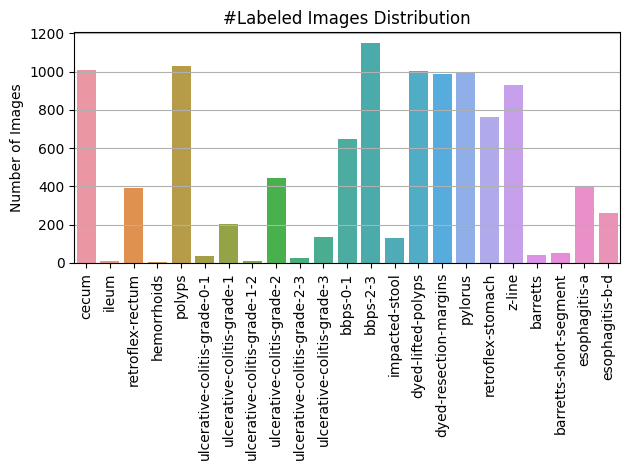

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = labeled_imgs_counter.keys()
values = labeled_imgs_counter.values()

sns.barplot(x=list(labels),
            y=list(values),)
plt.grid(axis='y')
plt.title('#Labeled Images Distribution')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Comment**: -> Imbalance classes

### Labeled images dataset class (PyTorch)
- Classification

In [6]:
df_labeled_img

Video file     Organ          Finding  \
0      000e3fee-7f5c-4819-9f9c-4c983b68888a  Lower GI            cecum   
1      001a41c2-2a5d-40b1-8fd5-b5f2f292277b  Lower GI            cecum   
2      006af0aa-2044-4477-964d-10d9e043fb78  Lower GI            cecum   
3      00832522-ab8e-4b98-bfce-93a777929571  Lower GI            cecum   
4      012ab888-64e6-4361-9745-f52b4a03ba75  Lower GI            cecum   
...                                     ...       ...              ...   
10657  f7dd198b-88f0-4566-b8f4-81c8c2fee1ed  Upper GI  esophagitis-b-d   
10658  f9a06ca3-3500-4e5e-ac46-110b52963a99  Upper GI  esophagitis-b-d   
10659  fb31e2c2-c8db-42b3-bbf1-564e42076a8e  Upper GI  esophagitis-b-d   
10660  fe6c191e-3da0-4f18-9e38-8f7a11097a3b  Upper GI  esophagitis-b-d   
10661  ff4f2ed2-69a8-455d-894a-8d536b324653  Upper GI  esophagitis-b-d   

              Classification  
0       anatomical-landmarks  
1       anatomical-landmarks  
2       anatomical-landmarks  
3       anatomical-landmarks  
4       anatomical-landmarks  
...                      ...  
10657  pathological-findings  
10658  pathological-findings  
10659  pathological-findings  
10660  pathological-findings  
10661  pathological-findings  

[10662 rows x 4 columns]

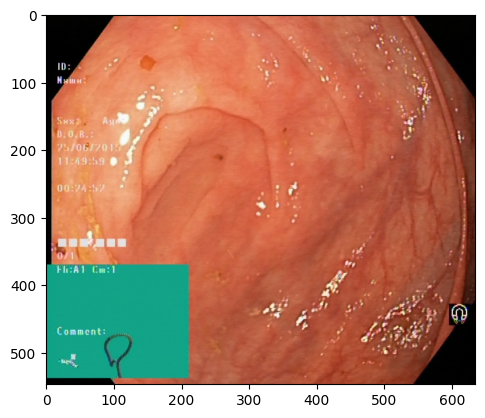

In [7]:
GI_dir = {'Lower GI':'lower-gi-tract',
          'Upper GI':'upper-gi-tract'}

idx = 0
img = df_labeled_img['Video file'][idx]
gi_tract = GI_dir[df_labeled_img['Organ'][idx]]
classification = df_labeled_img['Classification'][idx]
finding = df_labeled_img['Finding'][idx]
path = f'''{root_dir}/labeled-images/{gi_tract}/{classification}/{finding}/{img}.jpg'''
assert os.path.exists(path) == True, "File does not exist" # dir existance checking

from torchvision.io import read_image
image = read_image(path)

# Convert from CHW to HWC for visualization
image = image.permute(1, 2, 0)

plt.imshow(image)
plt.show()

In [8]:
import os
import pandas as pd
import torch
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# ======= generate label classes =======
classes = tuple([item for item in labeled_imgs_counter])

# ====== image dataset class =======
class LabeledImageDataset(Dataset):
    def __init__(self, labeled_csv_file, root_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(labeled_csv_file)
        self.transform = transform
        self.target_transform = target_transform
        self.classes = classes

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        
        # extract path from dataframe
        GI_dir = {'Lower GI':'lower-gi-tract',
                    'Upper GI':'upper-gi-tract'}

        img_id = self.img_labels['Video file'][idx]
        gi_tract = GI_dir[self.img_labels['Organ'][idx]]
        classification = self.img_labels['Classification'][idx]
        label_name = self.img_labels['Finding'][idx]
        
        img_path = f'''{root_dir}/labeled-images/{gi_tract}/{classification}/{label_name}/{img_id}.jpg'''
        assert os.path.exists(path) == True, "File does not exist" # dir existance checking
        
        image = read_image(img_path)
        label = torch.tensor(self.classes.index(label_name))
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
     # Consider __iter__() later
        
        
labeled_dataset = LabeledImageDataset(
    labeled_csv_file = f'{root_dir}/labeled-images/image-labels.csv',
    root_dir = root_dir
)
assert len(labeled_dataset) == 10662

### Image sizes

In [9]:
image_sizes = Counter()
for idx in range(len(labeled_dataset)):
    image = labeled_dataset[idx][0]
    image_size = tuple(image.shape)  # Get the (height, width) size
    image_sizes[image_size] += 1

****Comment****: Varying in sizes 751 different sizes / 10662 images

In [10]:
x = 20
top = image_sizes.most_common(x)
print(f'Top {x} common sizes {"="*20} \n {top}')
num_img = sum([entry[1] for entry in top])
print(f"{num_img}/10662 images = {num_img/10662:.2f}% total images")

Top 20 common sizes ==================== 
 [((3, 532, 633), 1311), ((3, 531, 633), 1272), ((3, 1071, 1349), 838), ((3, 1012, 1221), 788), ((3, 548, 635), 686), ((3, 1013, 1225), 437), ((3, 530, 623), 346), ((3, 547, 635), 294), ((3, 1015, 1225), 289), ((3, 1011, 1221), 253), ((3, 1020, 1221), 163), ((3, 529, 623), 162), ((3, 1013, 1221), 155), ((3, 524, 613), 149), ((3, 530, 622), 140), ((3, 530, 624), 105), ((3, 530, 628), 97), ((3, 532, 572), 95), ((3, 1014, 1225), 93), ((3, 548, 627), 85)]
7758/10662 images = 0.73% total images


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


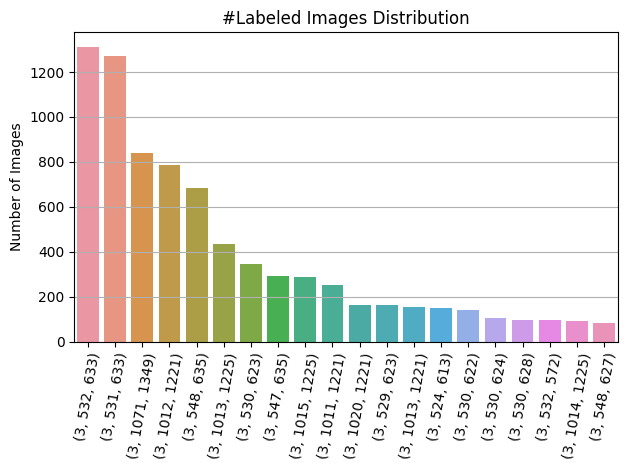

In [11]:
img_sizes = [str(entry[0]) for entry in top]
values = [entry[1] for entry in top]

sns.barplot(x=list(img_sizes),
            y=list(values),)
plt.grid(axis='y')
plt.title('#Labeled Images Distribution')
plt.ylabel('Number of Images')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

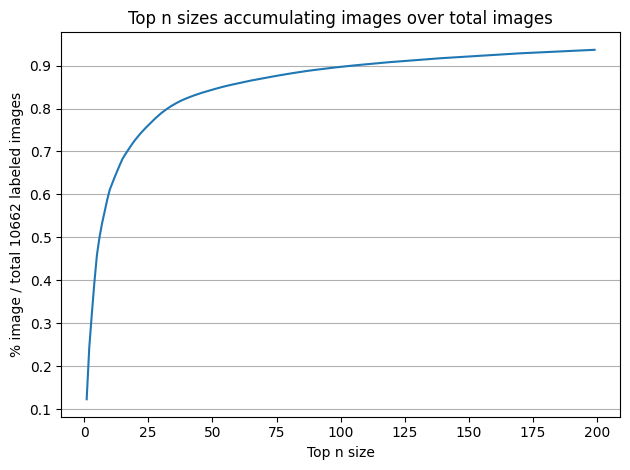

In [12]:
def percent_top(x):
    top = image_sizes.most_common(x)
    num_img = sum([entry[1] for entry in top])
    return num_img/10662

x = np.arange(1, 200)
y = []
for i in x:
    y.append(percent_top(i))

plt.plot(x, y)
plt.grid(axis='y')
plt.title('Top n sizes accumulating images over total images')
plt.xlabel('Top n size')
plt.ylabel('% image / total 10662 labeled images')
plt.tight_layout()
plt.show()

### Show images

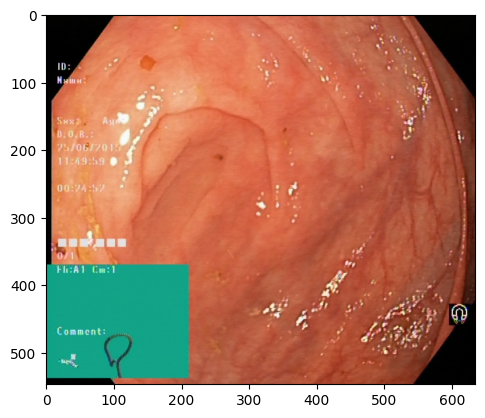

In [13]:
img = labeled_dataset[0][0]
img = img.permute(1, 2, 0)
plt.imshow(img)
plt.show()

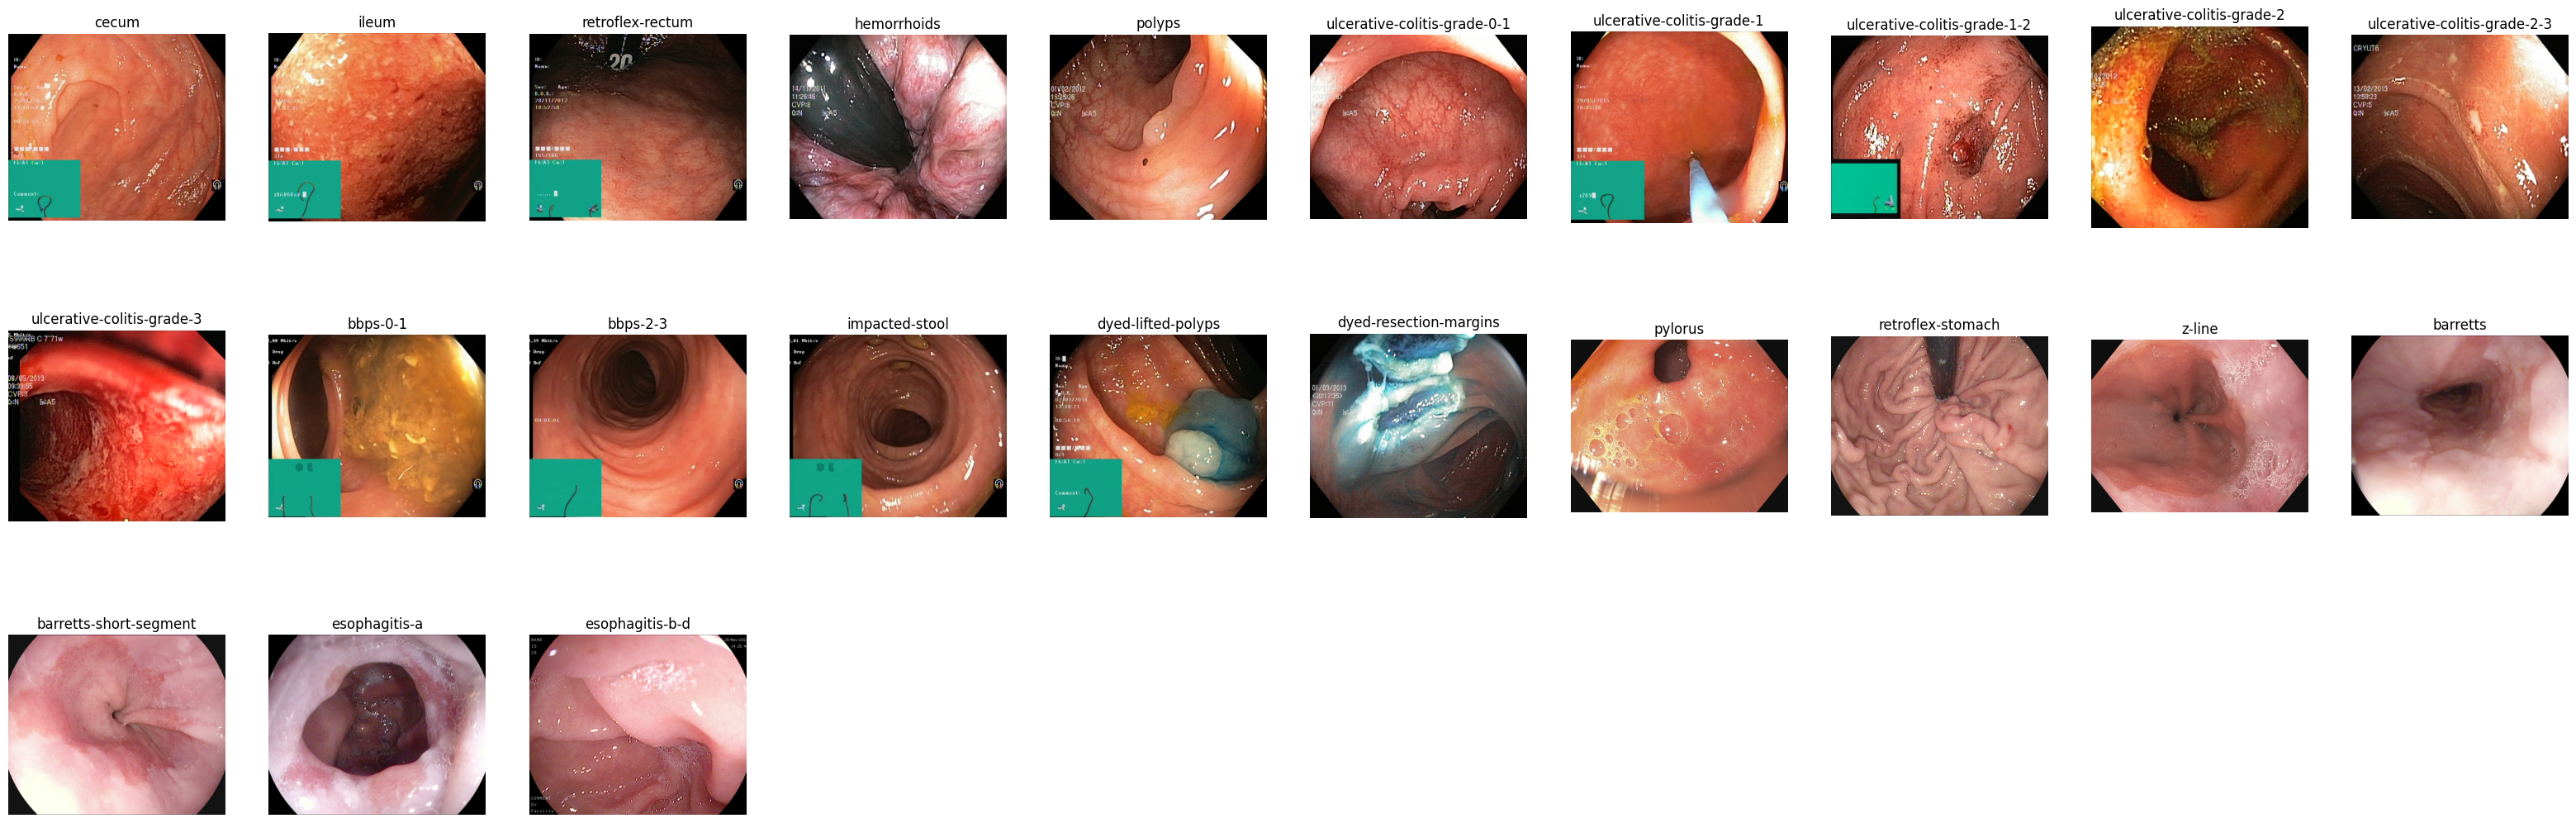

In [14]:
samples = [[] for _ in range(23)]
count = 0
for idx in range(len(labeled_dataset)):
    image, label = labeled_dataset[idx]
    if len(samples[label]) < 1:
        samples[label].append(image)

plt.figure(figsize=(40, 18))
for index in range(23):
    label = index % 23
    image = samples[label][index // 23]

    # Convert from CHW to HWC for visualization
    image = image.permute(1, 2, 0)

    # Convert from class index to class name
    label = labeled_dataset.classes[label]

    # Visualize the image
    plt.subplot(4, 10, index + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")
plt.show()

# Unlabeled images

In [15]:
unlabeled_dir = f'{root_dir}/unlabeled-images/images'
unlabels = os.listdir(unlabeled_dir)
print(f'{len(unlabels)} unlabeled images')

99417 unlabeled images


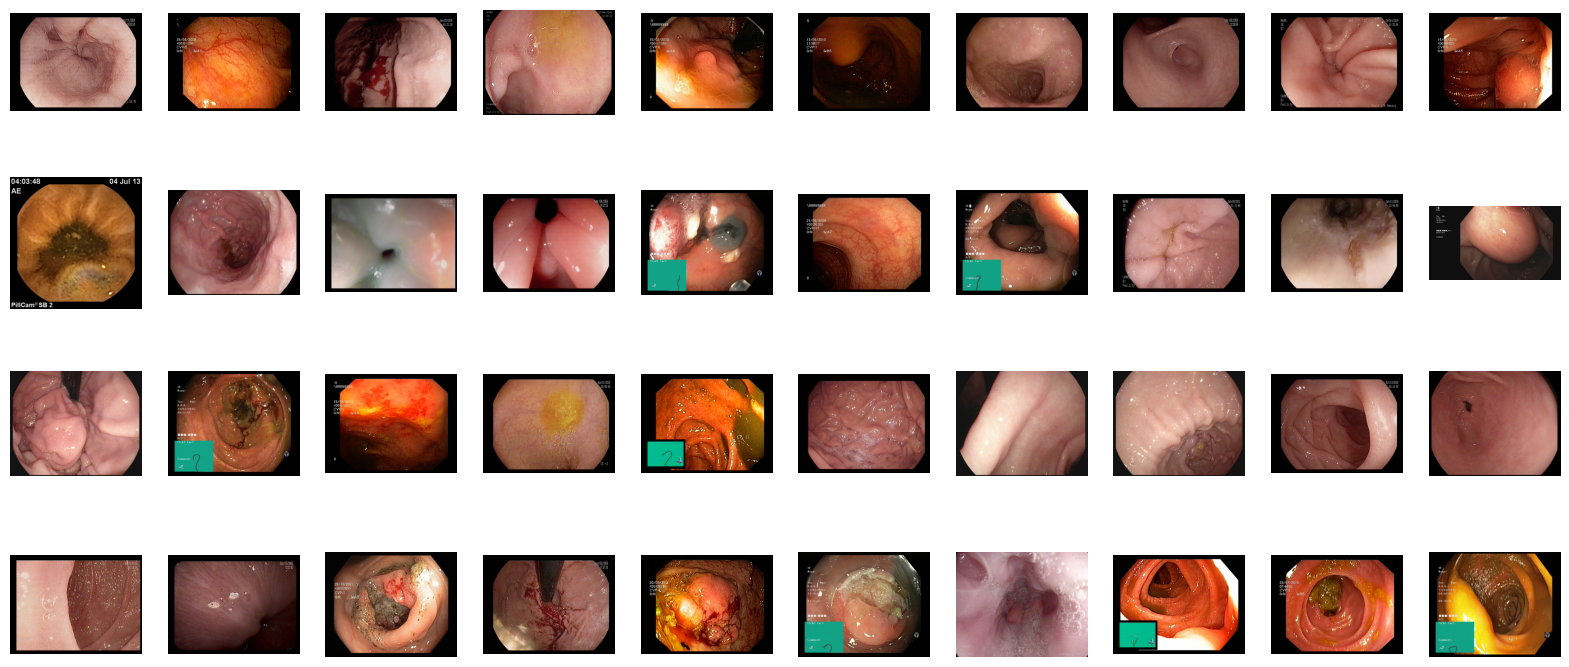

In [16]:
plt.figure(figsize=(20, 9))
for idx, path in enumerate(unlabels[:40]):
    image = read_image(f'{unlabeled_dir}/{path}')

    # Convert from CHW to HWC for visualization
    image = image.permute(1, 2, 0)

    plt.subplot(4, 10, idx + 1)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

# Segmented images

In [17]:
segmented_img_dir = f'{root_dir}/segmented-images/images'
segmented_mask_dir = f'{root_dir}/segmented-images/masks'
bbx_path = f'{root_dir}/segmented-images/bounding-boxes.json'

img_paths = os.listdir(segmented_img_dir)
print(f'{len(img_paths)} segmented images')

mask_paths = os.listdir(segmented_mask_dir)
print(f'{len(mask_paths)} segmented masks')

1000 segmented images
1000 segmented masks


- original image

torch.Size([531, 571, 3])
torch.Size([531, 571, 3])


(-0.5, 570.5, 530.5, -0.5)

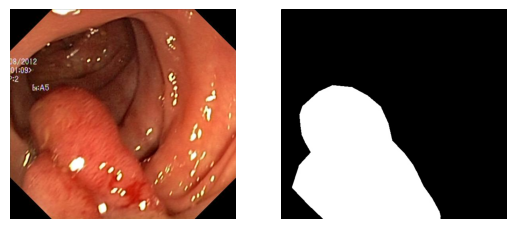

In [18]:
# Read and plot one image
for idx in range(0, 40, 2):
    # extract path
    break
index = int(idx/2)
img_path = f'{segmented_img_dir}/{img_paths[index]}'
mask_path = f'{segmented_mask_dir}/{mask_paths[index]}'
    
assert os.path.exists(img_path) == True
assert os.path.exists(mask_path) == True
img = read_image(img_path)
mask = read_image(mask_path)
img = img.permute(1, 2, 0)
mask = mask.permute(1, 2, 0)
print(img.shape)
print(mask.shape)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.axis("off")

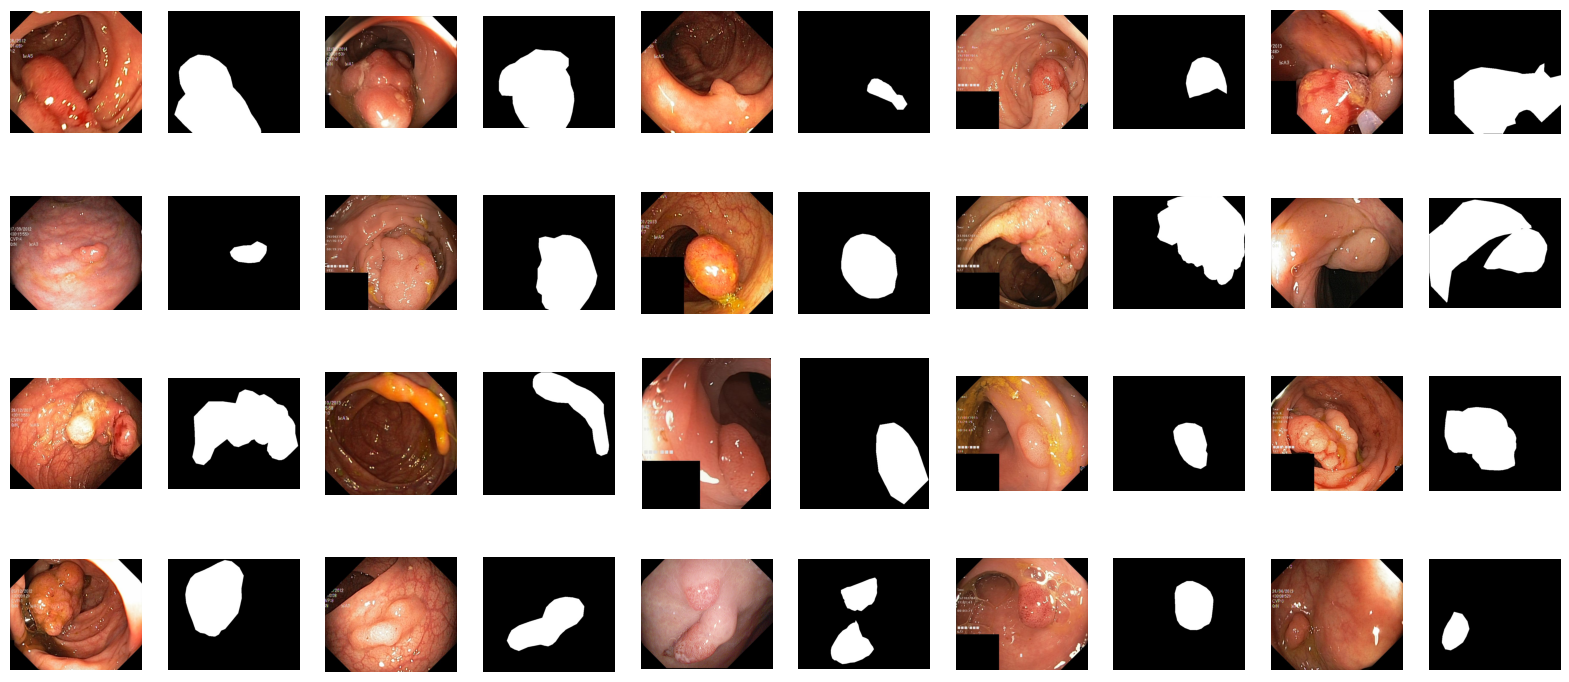

In [19]:
# Read and plot multiple images
plt.figure(figsize=(20, 9))
for idx in range(0, 40, 2):
    index = int(idx/2)
    img_path = f'{segmented_img_dir}/{img_paths[index]}'
    mask_path = f'{segmented_mask_dir}/{mask_paths[index]}'

    assert os.path.exists(img_path) == True
    assert os.path.exists(mask_path) == True
    # read img
    img = read_image(img_path)
    mask = read_image(mask_path)

    # permute tensor for visualize
    img = img.permute(1, 2, 0)
    mask = mask.permute(1, 2, 0)
    
    plt.subplot(4, 10, idx + 1)
    plt.imshow(img)
    plt.axis("off")
    
    plt.subplot(4, 10, idx + 2)
    plt.imshow(mask)
    plt.axis("off")
    
plt.show()

In [20]:
import json

with open(bbx_path, 'r') as f:
    bbx_file = json.load(f)
print(f'Length of bbx: {len(bbx_file)}')
df_bbx = pd.DataFrame(bbx_file)
df_bbx.T

Length of bbx: 1000


height width  \
cju0qkwl35piu0993l0dewei2    529   622   
cju0qoxqj9q6s0835b43399p4   1070  1348   
cju0qx73cjw570799j4n5cjze    529   619   
cju0roawvklrq0799vmjorwfv    528   622   
cju0rx1idathl0835detmsp84    528   617   
...                          ...   ...   
cju8b2rmgr52s0801p54eyflx    530   587   
cju8bj2ssrmlm0871gc2ug2rs    449   469   
cju8c1a0ws7o208181c6lbsom    546   625   
cju8cgi2kspp308011nxdtjp6    530   619   
cju8doa16u5gh0818w1ywda3q    529   622   

                                                                        bbox  
cju0qkwl35piu0993l0dewei2  [{'label': 'polyp', 'xmin': 38, 'ymin': 5, 'xm...  
cju0qoxqj9q6s0835b43399p4  [{'label': 'polyp', 'xmin': 194, 'ymin': 284, ...  
cju0qx73cjw570799j4n5cjze  [{'label': 'polyp', 'xmin': 187, 'ymin': 14, '...  
cju0roawvklrq0799vmjorwfv  [{'label': 'polyp', 'xmin': 486, 'ymin': 42, '...  
cju0rx1idathl0835detmsp84  [{'label': 'polyp', 'xmin': 292, 'ymin': 154, ...  
...                                                                      ...  
cju8b2rmgr52s0801p54eyflx  [{'label': 'polyp', 'xmin': 172, 'ymin': 114, ...  
cju8bj2ssrmlm0871gc2ug2rs  [{'label': 'polyp', 'xmin': 274, 'ymin': 184, ...  
cju8c1a0ws7o208181c6lbsom  [{'label': 'polyp', 'xmin': 138, 'ymin': 0, 'x...  
cju8cgi2kspp308011nxdtjp6  [{'label': 'polyp', 'xmin': 373, 'ymin': 242, ...  
cju8doa16u5gh0818w1ywda3q  [{'label': 'polyp', 'xmin': 0, 'ymin': 0, 'xma...  

[1000 rows x 3 columns]

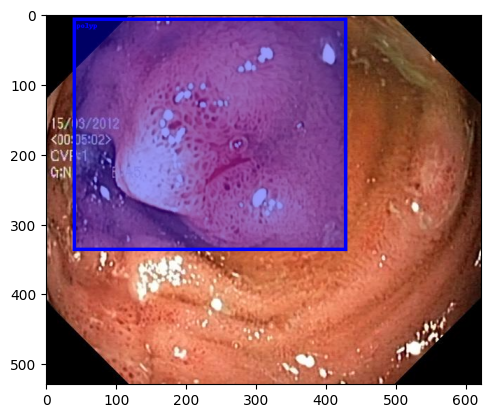

In [21]:
from torchvision.utils import draw_bounding_boxes

for box in df_bbx.columns:
    break
boxes = bbx_file[box]['bbox']
boxes = boxes[0]
box_tensor = torch.tensor([[boxes['xmin'], boxes['ymin'], boxes['xmax'], boxes['ymax']]])
img_path = f'{segmented_img_dir}/{box}.jpg'
img = read_image(img_path)

draw = draw_bounding_boxes(img, box_tensor, labels=['polyp'],colors=['blue'], width=5, fill=True)
plt.imshow(draw.permute(1, 2, 0))
# plt.show()

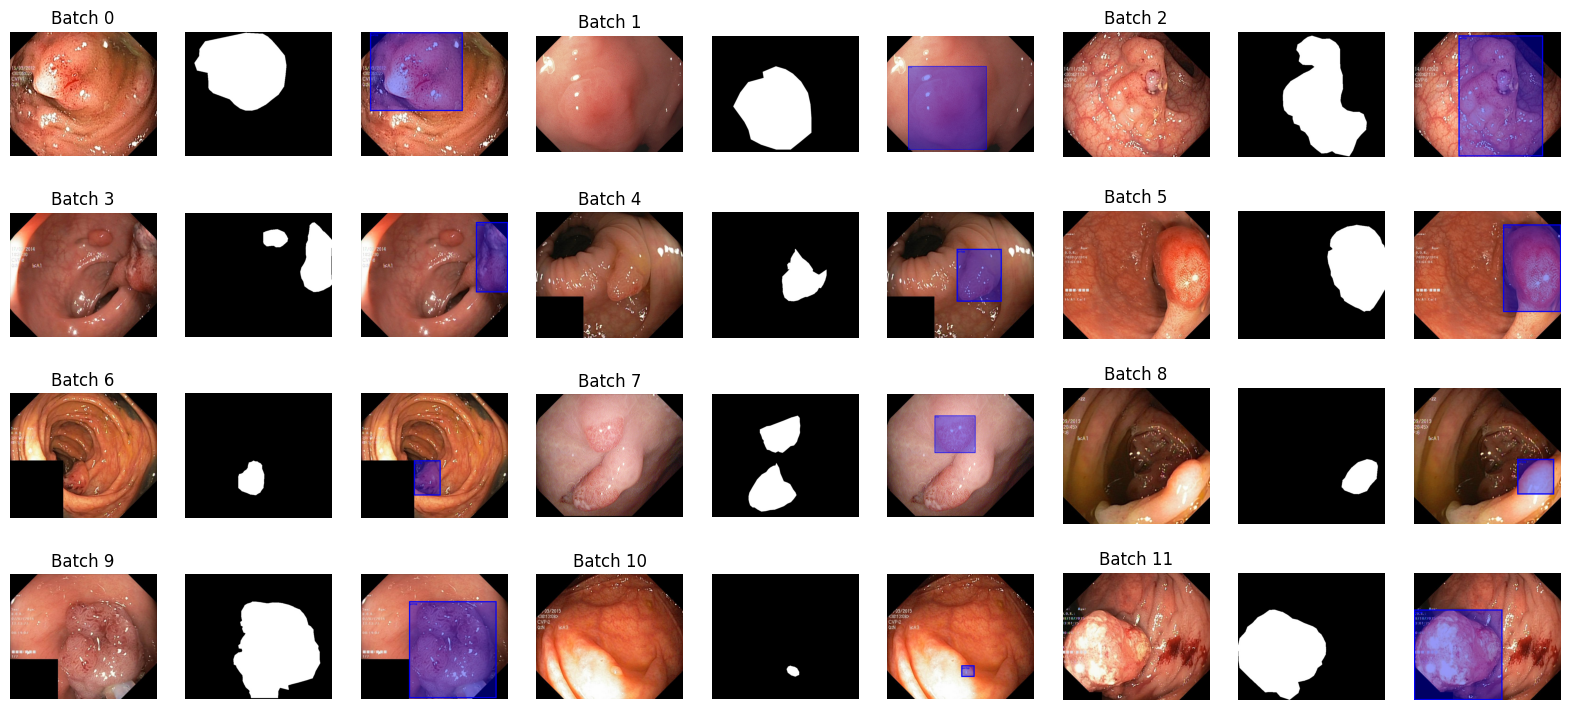

In [22]:
from torchvision.utils import draw_bounding_boxes

plt.figure(figsize=(20, 9))
for idx in range(0, 36, 3):
    index = int(idx/3)
   
    img_id = df_bbx.columns[index]
    img_path = f'{segmented_img_dir}/{img_id}.jpg'
    mask_path = f'{segmented_mask_dir}/{img_id}.jpg'
    box = df_bbx[img_id]['bbox'][0]

    img = read_image(img_path)
    mask = read_image(mask_path)
    box_tensor = torch.tensor([[box['xmin'], box['ymin'], box['xmax'], box['ymax']]])

    # ==== Visualization ========
    # permute tensor for visualize
    draw = draw_bounding_boxes(img, box_tensor, labels=['polyp'],colors=['blue'], width=5, fill=True)
    img = img.permute(1, 2, 0)
    mask = mask.permute(1, 2, 0)

    # original img
    plt.subplot(4, 9, idx + 1)
    plt.imshow(img)
    plt.axis("off")

    # segmented mask
    plt.title(f"Batch {index}")
    plt.subplot(4, 9, idx + 2)
    plt.imshow(mask)
    plt.axis("off")

    # bounding box
    plt.subplot(4, 9, idx + 3)
    plt.imshow(draw.permute(1, 2, 0))
    plt.axis("off")
    
#     break


# Annotated video

In [23]:
df_labeled_vid

Video file     Organ             Finding 1  \
0    44f1e701-2d9a-4f25-a5a8-424bb549844d  Lower GI           anastomosis   
1    8f9e4085-98c4-4f69-99e6-3945dda43c05  Lower GI           anastomosis   
2    b85566cc-a3da-4044-b98c-43732ae5dd0b  Lower GI           anastomosis   
3    f918a7be-5bcb-47b1-8a4a-d93f33e9e5f5  Lower GI           anastomosis   
4    cafa734d-74ea-48f2-b58a-3f3151a99177  Lower GI           anastomosis   
..                                    ...       ...                   ...   
369  e8e36826-f370-4f4a-ae81-caba8fb3c604  Upper GI     retroflex stomach   
370  67e7ae14-0595-466e-aa7b-9d8a06c59e12  Upper GI           esophagitis   
371  7d97a4c5-bbf6-46f9-b558-fec238ac17ae  Lower GI  self-expanding stent   
372  871c9774-5465-4a61-bca5-aa876511e91a  Upper GI                 ulcer   
373  14873d0e-96bc-464c-869d-78745fa8cb81  Upper GI  barrett's oesophagus   

              Classification 1 Detailed description of finding  \
0        Pathological findings                             NaN   
1        Pathological findings                             NaN   
2        Pathological findings                             NaN   
3        Pathological findings                             NaN   
4        Pathological findings                             NaN   
..                         ...                             ...   
369       Anatomical landmarks                             NaN   
370      Pathological findings                             NaN   
371  Therapeutic interventions                             NaN   
372      Pathological findings                             NaN   
373      Pathological findings                             NaN   

                           Finding 2           Classification 2  
0                                NaN                        NaN  
1                              stent  Therapeutic interventions  
2                                NaN                        NaN  
3    incision in colonoc anastomosis  Therapeutic interventions  
4    incision in colonoc anastomosis  Therapeutic interventions  
..                               ...                        ...  
369                           Z-line       Anatomical landmarks  
370                    Normal mucosa                        NaN  
371                              NaN                        NaN  
372                              NaN                        NaN  
373                              NaN                        NaN  

[374 rows x 7 columns]

In [24]:
print(f'Number of videos: {len(df_labeled_vid)}')
df_labeled_vid.columns

Number of videos: 374


Index(['Video file', 'Organ', 'Finding 1', 'Classification 1',
       'Detailed description of finding', 'Finding 2', 'Classification 2'],
      dtype='object')

In [25]:
print(len(df_labeled_vid['Detailed description of finding'].unique()))
df_labeled_vid['Detailed description of finding'].unique()

61


array([nan, 'lugol staining', 'irregular mucosa', 'cancer, stomach',
       'cancer, esophagus', 'clipping polyp stalk', 'pseudomembrane',
       'Endoscopic mucosal resection', 'flat polyp',
       'polyp lifted resected', 'snare resection 1p polyp',
       'Polyp before and after lifting and resection',
       'Endoscopic mucosal resection, bleeding',
       'Endoscopic mucosal resection, bleeding treated with clip',
       'endoscopic mucosal resection', 'incomplete resection',
       'retrieval of the polyp with a basket', 'papilla vateri',
       'oesophagitis D', 'gastric antral vascular ectasia ', 'Duodenum',
       'moving worms', 'Lateral spreading tumor', 'serrated lesion', '¨',
       'villous polyp', '2 polyps', '4 polyps',
       'Bleeding after polyp resection', 'bleeding after polyp resection',
       'probably malignant polyp', 'lipoma, duodenum', 'polyp, duodenum',
       'gastric fundic polyps', 'ligation bleeding polyp',
       'ongoing polyp resection', 'plastic sna

In [26]:
print(len(df_labeled_vid['Finding 1'].unique()))
df_labeled_vid['Finding 1'].unique()

29


array(['anastomosis', "barrett's oesophagus", 'BBPS 0-1', 'BBPS 2-3',
       'cancer', 'cancer, colorectal ', 'cavity of anastomotic leak',
       'cecum', 'clip placement', 'colitis', 'dyed lifted polyps',
       'dyed resection margins', 'ERCP', 'esophagitis',
       'gastric banding perforated', 'GAVE', 'hemorrhoids',
       'optimal view', 'parasites', 'polyps', 'snare resection',
       'pylorus', 'reduced view', 'retroflex stomach',
       'self-expanding stent', 'stenosis', 'ulcer', 'varices', 'Z-line'],
      dtype=object)

In [27]:
print(len(df_labeled_vid['Finding 2'].unique()))
df_labeled_vid['Finding 2'].unique()

36


array([nan, 'stent', 'incision in colonoc anastomosis', 'normal mucosa',
       'polyp', 'ileocecal valve', 'chormoscopy', 'dyed lifted flat',
       'dyed resction margin', 'dyed resection margin',
       'retroflex rectum', 'Coaggrasper', 'dyed lifted resection margins',
       'polypectomi, piece meal EMR', 'ileo-cecal valve', 'inflammation',
       'APC', 'hemospray', 'lipoma?', 'serrated?', 'marking of the polyp',
       'very complex polyp, appear disapear, reapear', 'coagrasper',
       'hematine, mix of old blod and liquide', 'duodenum',
       'duodenal diverticula', 'Placement of duodenal tube', 'pylorus',
       'clip placement', 'injection', 'heatherprobe',
       'distal oesophagus, ', 'Normal mucosa', 'Band ligation', 'Z-line',
       'BBPS 2-3'], dtype=object)

In [28]:
print(len(df_labeled_vid['Classification 2'].unique()))
df_labeled_vid['Classification 2'].unique()

5


array([nan, 'Therapeutic interventions', 'Pathological findings',
       'Anatomical landmarks', 'Quality of mucosal views'], dtype=object)